# Fitting Emission Lines with PyMC3, and NUTS: Proof of Concept

This notebook extends fitting multiple lines to incorporate PyMC3.

## Environment

Let's initialize the environment.

In [1]:
import time, sys, os
import theano

%pylab
%matplotlib inline

# re-defining plotting defaults
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'xtick.color': 'k'})
rcParams.update({'ytick.color': 'k'})
rcParams.update({'font.size': 30})

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


## Basic Idea

Let's define our emission line model, which reads a series of lists of a each line's mean, standard deviation, and amplitude 

$$ \boldsymbol{\theta} = \lbrace \boldsymbol{\theta}_i \rbrace = \lbrace \mu_i, \sigma_i, \alpha_i \rbrace $$ 

and models the resulting emission as a sum of Gaussians such that

$$ 
\mathbf{F}(\boldsymbol{\theta}) = \sum_i \mathbf{F}_i(\boldsymbol{\theta}_i) 
= \sum_i \alpha_i \mathcal{N}(\boldsymbol{\lambda} \,|\, \mu_i, \sigma_i^2)
$$

In [2]:
# Normal/Gaussian
def gaussian(mu, std, x):    
    dif = x - mu
    norm = 1. / sqrt(2*pi) / std
    return norm * exp(-0.5 * square(dif/std))

# emission line model
def emline(theta):
    mu, sigma, alpha = theta
    return exp(alpha) * gaussian(mu, sigma, x)

# combination of emission lines
def emlines(thetas, return_lines=False):
    thetas = array(thetas).reshape(-1,3)
    lines = array([emline(theta) for theta in thetas])
    if return_lines: 
        return lines.sum(axis=0), lines
    else:
        return lines.sum(axis=0)

Our toy model here is a bunch of slightly overlapping noisy emission lines.

## Statistical Model

### Likelihood

As before, our likelihood is simply

$$ P(\mathbf{\hat{F}} \,|\, \boldsymbol{\theta}) = \mathcal{N}\left[\Delta\mathbf{\hat{F}}(\boldsymbol{\theta}) \:|\: \mathbf{0}, \mathbf{\hat{C}} \right] $$

where $\Delta\mathbf{\hat{F}}(\boldsymbol{\theta}) \equiv \mathbf{F}(\boldsymbol{\theta}) - \mathbf{\hat{F}}$. The corresponding log-likelihood is then

$$ \ln P(\mathbf{\hat{F}} \,|\, \boldsymbol{\theta}) = -\frac{1}{2}\Delta\mathbf{\hat{F}}(\boldsymbol{\theta})^T \mathbf{\hat{C}}^{-1} \Delta\mathbf{\hat{F}}(\boldsymbol{\theta}) + Z_{\mathbf{\hat{F}}} $$

where $Z_{\mathbf{\hat{F}}}$ is a normalization constant.

### Prior

If we assume a (multivariate) Normal prior on $\boldsymbol{\theta}$ with mean $\boldsymbol{\mu}_{\boldsymbol{\theta}}$ and covariance $\mathbf{C}_{\boldsymbol{\theta}}$ such that

$$ P(\boldsymbol{\theta}) = \mathcal{N}(\boldsymbol{\theta} \,|\, \boldsymbol{\mu}_{\boldsymbol{\theta}}, \mathbf{C}_{\boldsymbol{\theta}}) \quad, $$

our posterior then simply becomes 

$$ \ln P(\boldsymbol{\theta} \,|\, \mathbf{\hat{F}}) = -\frac{1}{2} \Delta\mathbf{\hat{F}}(\boldsymbol{\theta})^T \mathbf{\hat{C}}^{-1} \Delta\mathbf{\hat{F}}(\boldsymbol{\theta}) + Z_{\mathbf{\hat{F}}} -\frac{1}{2} \Delta\boldsymbol{\theta}^T \mathbf{C}_{\boldsymbol{\theta}}^{-1} \Delta\boldsymbol{\theta} + Z_{\boldsymbol{\theta}} $$

where $\Delta\boldsymbol{\theta} \equiv \boldsymbol{\mu}_{\boldsymbol{\theta}} - \boldsymbol{\theta}$.

Note that, in this version of our implementation, our prior is **perturbative** in $\alpha$. In other words, our prior is Normal in $\Delta\ln\alpha$ relative to our chosen mean value. We assign correlations among our mean offsets to be close to one (i.e. all lines move together), correlations among our standard deviations to be moderately strong (line widths are very similar), and correlations among our amplitudes to be moderate.

### Constants

For completeness, we note that our constants are equal to

$$ 
Z_{\mathbf{\hat{F}}} = -\frac{1}{2} ( N_{\mathbf{\hat{F}}} \ln 2\pi + \ln|\mathbf{\hat{C}}| ) \quad , \quad 
Z_{\boldsymbol{\theta}} = -\frac{1}{2} ( N_{\boldsymbol{\theta}} \ln 2\pi + \ln|\mathbf{C}_{\boldsymbol{\theta}}| ) \quad .
$$

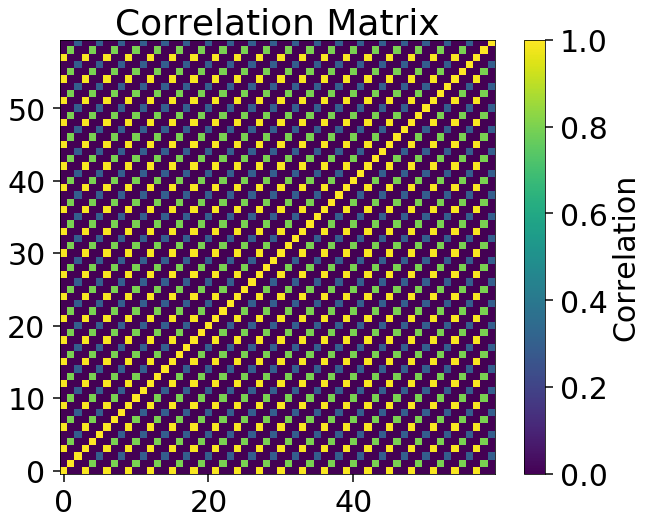

In [3]:
# initialize observing properties
x = arange(-10, 110, 0.5) # wavelength grid
noise = 10. # background noise

# initialize ensemble of lines
Nlines = 20
Ntheta, Ndata = Nlines*3, len(x) # number of parameters, data points

# prior mean
mean_theta = zeros(Ntheta)
mean_theta[0::3] = arange(0, 100, 5.) # mean is initial theta without the noise or shift
mean_theta[1::3] = 1.
mean_theta[2::3] = log(200.) # set amplitudes to mean

# prior correlation
corr_theta = zeros((Ntheta, Ntheta)) # initialize diagonals
corr_theta[0::3, 0::3] = 0.99 # set mean correlations
corr_theta[1::3, 1::3] = 0.8 # set standard devation correlations
corr_theta[2::3, 2::3] = 0.3 # set amplitude correlations
corr_theta[arange(Ntheta),arange(Ntheta)] = ones(Ntheta) # set diagonals

# prior covariance
sig_theta = tile([2., 0.25, log(1.2)], Nlines) # standard deviation of {mu, sigma, ln(alpha)}
cov_theta = array([[corr_theta[i][j] * sig_theta[i] * sig_theta[j] 
                    for i in xrange(Ntheta)] 
                   for j in xrange(Ntheta)])

figure(figsize=(10,8))
imshow(corr_theta, origin='bottom', interpolation='nearest')
title('Correlation Matrix')
colorbar(label='Correlation')
tight_layout()

## Mock Data

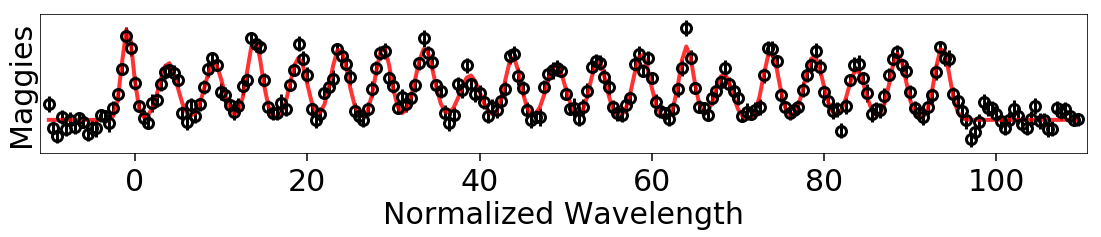

In [4]:
# initialize single line properties
theta_true = multivariate_normal(mean_theta, cov_theta)

# initialize noiseless and noisy data
y_true = emlines(theta_true)
y_err = normal(noise, size=Ndata)
y_obs = normal(y_true, y_err)

figure(figsize=(16,4))
errorbar(x, y_obs, yerr=y_err, marker='o', markerfacecolor='none', markeredgecolor='black', markeredgewidth=3,
         markersize=10, ecolor='black', lw=3, linestyle='None')
plot(x, y_true, lw=4, alpha=0.8, color='red')
xlim([x.min()-1, x.max()+1])
yticks([])
xlabel('Normalized Wavelength')
ylabel('Maggies')
tight_layout()

## Model Setup

Let's now initialize our model in PyMC3.

In [5]:
import pymc3
from pymc3 import Model, MvNormal, Normal

model = Model()

with model:
    
    # prior
    theta = MvNormal('theta', mu=mean_theta, cov=cov_theta, shape=Ntheta)
    
    # model
    y_ind = [exp(-0.5 * square((x - theta[3*i])/theta[3*i+1]) + theta[3*i+2]) / (sqrt(2*pi) * theta[3*i+1])
               for i in xrange(Nlines)]
    y = sum(y_ind, axis=0)
    
    # likelihood
    Y = Normal('maggies', mu=y, sd=y_err, observed=y_obs)

## Standard Approach: Optimization

We can easily attempt to find the *maximum a posteriori* (MAP) solution using a minimization routine, as shown below.

In [6]:
from scipy import optimize
from pymc3 import find_MAP
results = find_MAP(model=model, start={'theta': mean_theta}, fmin=optimize.fmin_powell)

Optimization terminated successfully.
         Current function value: 827.218596
         Iterations: 5
         Function evaluations: 3512


MAP solution: [ -0.89466145   0.77015648   5.32776584   3.92296623   1.00913818
   5.2390026    9.03360448   0.99142931   5.32102631  13.90745087
   0.90162809   5.54650641  19.03422957   0.86586836   5.34195594
  23.76501205   1.00916219   5.48084937  28.77092189   0.95932159
   5.41408967  33.73561067   1.04230058   5.57432582  38.723662
   1.06395202   5.14091749  43.86658933   0.89456583   5.28778081
  48.78104305   0.99346654   5.29860037  53.7307688    0.98831809
   5.35767967  58.88582218   1.04515196   5.45155454  64.01923825
   0.76781112   5.33933884  68.56870178   1.05806228   5.16311249
  73.85969779   0.86139184   5.38407299  78.83102704   1.0052947
   5.39822264  83.84705773   0.88692252   5.19821493  88.55020703
   1.03589635   5.47329462  93.81034823   0.93956346   5.42170512]
Truth: [ -0.86236193   0.65427449   5.33712085   3.85986586   1.04012157
   5.32332888   9.16065761   1.02564211   5.30758604  13.8830507    0.853179
   5.46617707  19.00096267   0.94970138   5.31

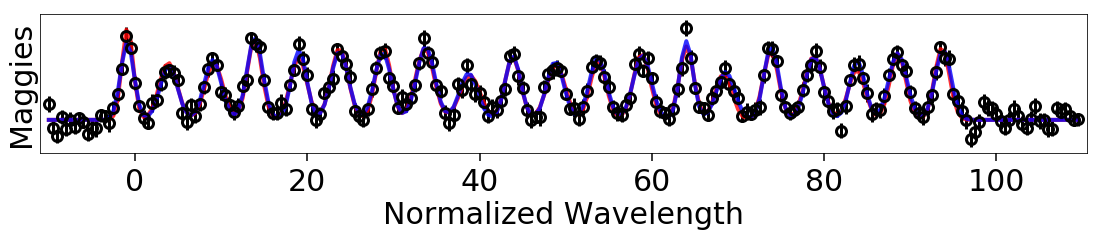

In [7]:
figure(figsize=(16,4))
errorbar(x, y_obs, yerr=y_err, marker='o', markerfacecolor='none', markeredgecolor='black', markeredgewidth=3,
         markersize=10, ecolor='black', lw=3, linestyle='None')
plot(x, y_true, lw=4, alpha=0.8, color='red')
plot(x, emlines(results['theta']), lw=4, alpha=0.8, color='blue')
xlim([x.min()-1, x.max()+1])
yticks([])
xlabel('Normalized Wavelength')
ylabel('Maggies')
tight_layout()

print 'MAP solution: {0}'.format(results['theta'])
print 'Truth: {0}'.format(theta_true)

## Probing the Posterior with Hamiltonian Monte Carlo

We are interested in probing the full posterior, not just the MAP solution. As before, we use **Hamiltonian Monte Carlo (HMC)** to take advantage of the fact that (1) our likelihood surface is smooth, (2) the gradients are analytic, and (3) the scaling with dimensionality is quite good.

### Hamiltonian Dynamics

In brief, we can sample from the distribution by simulating a particle "rolling" around the potential with position $\mathbf{q}$ and momentum $\mathbf{p}$ such that 

$$ P(\mathbf{q}, \mathbf{p}) = \frac{1}{Z} \exp\left[ -\frac{H(\mathbf{q}, \mathbf{p})}{T} \right] = \frac{1}{Z} \exp\left[ -\frac{U(\mathbf{q})}{T} \right] \exp\left[ -\frac{K(\mathbf{p})}{T} \right] $$

where the Hamiltonian $H(\mathbf{q},\mathbf{p}) = U(\mathbf{q}) + K(\mathbf{p})$ is just a sum over the potential energy $U(\mathbf{q})$ and kinetic energy $K(\mathbf{p})$ of the particle, $T$ is the temperature of the system, and $Z$ is a normalizing constant.

Letting:
- our position $\mathbf{q} \equiv \boldsymbol{\theta}$ be our parameters of interest, 
- our momentum $\mathbf{p} \equiv \mathbf{M} \boldsymbol{\dot{\theta}}$ be the change in our parameters of interest multiplied by a **mass matrix** $\mathbf{M}$, 
- our potential energy $U(\mathbf{q}) = −\ln P(\mathbf{q} \,|\, \mathbf{\hat{F}}) $ be the negative log of our posterior, 
- and our kinetic energy $K(p) = \frac{1}{2} \mathbf{p}^T \mathbf{M}^{-1} \mathbf{p}$ be in a standard quadratic form, 

we get

$$ P(\mathbf{q}, \mathbf{p}) \propto \exp\left[ -\frac{1}{2} \mathbf{p}^T \mathbf{M}^{-1} \mathbf{p} \right] \, P(\mathbf{q} \,|\, \mathbf{\hat{F}}) $$

where we have set $T=1$.

Since the Hamiltonian is conserved, the system evolves according to Hamilton's equations such that

$$ 
\frac{\partial \mathbf{q}}{\partial t} = \nabla_{\mathbf{p}} K = \mathbf{M}^{-1} \mathbf{p} \quad , \quad 
\frac{\partial \mathbf{p}}{\partial t} = - \nabla_{\mathbf{q}} U = \nabla_{\mathbf{q}} \ln P( \mathbf{q} \,|\, \mathbf{\hat{F}})
$$

where $U(\boldsymbol{\theta})$ is defined as above. 

### Our Potential/Posterior Gradients

In our original notation, the gradient of our log-posterior can be written as

$$ \nabla_{\boldsymbol{\theta}} \ln P(\boldsymbol{\theta} \,|\, \mathbf{\hat{F}}) = -\nabla_{\boldsymbol{\theta}} \mathbf{F}(\boldsymbol{\theta})^T \mathbf{\hat{C}}^{-1} \Delta\mathbf{\hat{F}}(\boldsymbol{\theta}) - \nabla_{\boldsymbol{\theta}} \boldsymbol{\theta}^T \mathbf{C}_{\boldsymbol{\theta}}^{-1} \Delta\boldsymbol{\theta} \quad . $$

Given that $\mathbf{F}(\boldsymbol{\theta} = \lbrace \mu_i, \sigma_i, \alpha_i \rbrace) = \sum_i \mathbf{F}_i(\boldsymbol{\theta}_i) = \sum_i \alpha_i \mathcal{N}(\boldsymbol{\lambda} \,|\, \mu_i, \sigma_i^2)$, the partials for each component can be written as:

$$
\frac{\partial \mathbf{F}}{\partial \mu_i} = \sigma_i^{-2} (\boldsymbol{\lambda} - \mu_i) \bullet \alpha_i \mathcal{N}(\boldsymbol{\lambda} \,|\, \mu_i, \sigma_i^2) 
= \boxed{ \sigma_i^{-2} (\boldsymbol{\lambda} - \mu_i) \bullet \mathbf{F}_i(\boldsymbol{\theta}_i) } \\
\frac{\partial \mathbf{F}}{\partial \sigma_i} = (\sigma_i^{-3} (\boldsymbol{\lambda} - \mu_i)^2 - \sigma_i^{-1}) \bullet \alpha_i \mathcal{N}(\boldsymbol{\lambda} \,|\, \mu_i, \sigma_i^2) 
= \boxed{ (\sigma_i^{-3} (\boldsymbol{\lambda} - \mu_i)^2 - \sigma_i^{-1}) \bullet \mathbf{F}_i(\boldsymbol{\theta}_i) } \\
\frac{\partial \mathbf{F}}{\partial \alpha_i} = \mathcal{N}(\boldsymbol{\lambda} \,|\, \mu_i, \sigma_i^2) 
= \boxed{ \alpha_i^{-1} \bullet \mathbf{F}_i(\boldsymbol{\theta}_i) }
$$

where $\bullet$ indicates element-wise multiplication (i.e. the Hadamard product). Since by definition the gradient of $\boldsymbol{\theta}$ with respect to $\boldsymbol{\theta}$ is just the identity matrix, after defining

$$ 
\mathbf{G}(\boldsymbol{\theta}) \equiv 
\begin{bmatrix}
\vdots \\
\underline{\mathbf{F}}_i(\boldsymbol{\theta}_i) \bullet \mathbf{J}_i(\boldsymbol{\theta}_i) \\
\vdots
\end{bmatrix} \quad , \quad
\underline{\mathbf{F}}_i(\boldsymbol{\theta}_i) \equiv 
\begin{bmatrix}
\mathbf{F}_i(\boldsymbol{\theta}_i) \\
\mathbf{F}_i(\boldsymbol{\theta}_i) \\
\mathbf{F}_i(\boldsymbol{\theta}_i)
\end{bmatrix} \quad , \quad
\mathbf{J}_i(\boldsymbol{\theta}_i) \equiv
\begin{bmatrix}
\sigma_i^{-2} (\boldsymbol{\lambda} - \mu_i) \\
\sigma_i^{-3} (\boldsymbol{\lambda} - \mu_i)^2 - \sigma_i^{-1} \\
\alpha_i^{-1} \mathbf{1}
\end{bmatrix}
$$

our gradient can be written as

$$ \nabla_{\boldsymbol{\theta}} \ln P(\boldsymbol{\theta} \,|\, \mathbf{\hat{F}}) = - \mathbf{G}(\boldsymbol{\theta}) \mathbf{\hat{C}}^{-1} \Delta\mathbf{\hat{F}}(\boldsymbol{\theta}) - \mathbf{C}_{\boldsymbol{\theta}}^{-1} \Delta\boldsymbol{\theta} \quad . $$

### Evolving the System

We can numerically evolve our system for $L$ small timesteps $\epsilon$ using the **leapfrog method**:

\begin{align}
\textrm{Initial momentum half step:}& \quad \mathbf{p}(t+\epsilon/2) = \mathbf{p}(t) + \epsilon/2 \times -\nabla_{\mathbf{q}} U(\mathbf{q}(t)) \\
\textrm{Position leapfrog:}& \quad \mathbf{q}(t+\epsilon) = \mathbf{q}(t) + \epsilon \times \nabla_{\mathbf{p}} K(t+\epsilon/2) \\
\textrm{Momentum leapfrog:}& \quad \mathbf{p}(t+\epsilon+\epsilon/2) = \mathbf{p}(t+\epsilon/2) + \epsilon \times -\nabla_{\mathbf{q}} U(\mathbf{q}(t+\epsilon)) \\
\vdots \\
\textrm{Momentum leapfrog:}& \quad \mathbf{p}(t+(L-1)\epsilon+\epsilon/2) = \mathbf{p}(t+(L-2)\epsilon+\epsilon/2) + \epsilon \times -\nabla_{\mathbf{q}} U(\mathbf{q}(t+(L-1)\epsilon)) \\
\textrm{Position leapfrog:}& \quad \mathbf{q}(t+L\epsilon) = \mathbf{q}(t+(L-1)\epsilon) + \epsilon \times \nabla_{\mathbf{p}} K(t+(L-1)\epsilon+\epsilon/2) \\
\textrm{Final momentum half step:}& \quad \mathbf{p}(t+L\epsilon) = \mathbf{p}(t+(L-1)\epsilon+\epsilon/2) + \epsilon/2 \times --\nabla_{\mathbf{q}} U(\mathbf{q}(t+L\epsilon)) \\
\end{align}

### HMC Algorithm

First, we change the momentum (i.e. give the particle a "kick" in a random direction) by sampling from our energy distribution 

$$ \mathbf{p} \sim \exp\left[ -\frac{1}{2} \mathbf{p}^T \mathbf{M}^{-1} \mathbf{p} \right] \propto \mathcal{N}(\mathbf{p} \,|\, \mathbf{0}, \mathbf{M}) $$

which is proportional to a multivariate Normal with mean $\mathbf{0}$ and covariance $\mathbf{M}$.

Next, we propose a new state using Hamiltonian dynamics. Starting at $(\mathbf{q}, \mathbf{p})$, we evolve the system for $L$ steps of size $\epsilon$. The momentum variables are then negated (although this rarely needs to be done in practice), leaving us with the proposed state $(\mathbf{q}^*, \mathbf{p}^*)$.

Finally, we perform a **Metropolis update**, accepting the proposed state with probability

$$ \min \left\lbrace 1, \, \exp\left[-H(\mathbf{q}^*, \mathbf{p}^*) + H(\mathbf{q}, \mathbf{p}) \right] \right\rbrace = \min \left\lbrace 1, \, \exp\left[-U(\mathbf{q}^*) + U(\mathbf{q}) - K(\mathbf{p}^*) + K(\mathbf{p}) \right] \right\rbrace $$

### Tuning Hyperparameters and Optimizing Samples

To optimize our results, we use the adaptive **No U-Turn Sampler (NUTS)** implementation of MCMC as defined by Hoffman & Gelman (2011) which allows us to auto-tune $\epsilon$ and $L$ to optimize performance.

** ADD TEXT DETAILING THESE THINGS**

### Generating Samples

Now that everything's set up, let's generate some samples.

In [8]:
from pymc3 import NUTS, sample

Nsamples = 10000

with model:

    # start at MAP estimate
    start = results

    # draw posterior samples
    trace = sample(Nsamples, start=start, live)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -939.21: 100%|██████████| 200000/200000 [01:42<00:00, 1952.53it/s]
Finished [100%]: Average ELBO = -939.11
100%|██████████| 10000/10000 [02:02<00:00, 81.66it/s]


As with a typical **Markov Chain Monte Carlo (MCMC)** sampler, our HMC sampler only generates independent samples from the posterior after it has **burned in** to the stationary distribution. Unlike a typical MCMC sampler, however, our HMC sampler burns in *extremely* fast by taking advantage of the gradient to roll down the potential (i.e. our posterior).

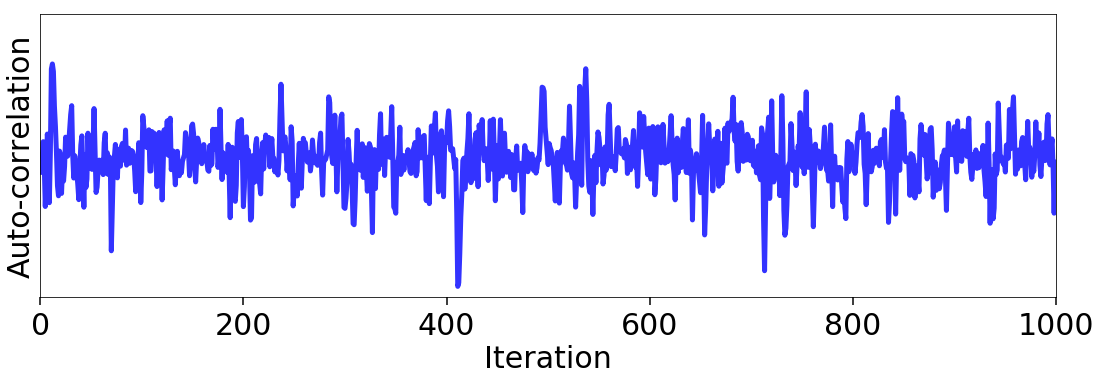

In [11]:
samples = trace['theta']

# plot lag=1 autocorrelation
figure(figsize=(16,6))
autocorr = array([correlate(samples[i], samples[i+1]) for i in arange(Nsamples-1)]).flatten()
plot(arange(Nsamples-1), autocorr, lw=5, color='blue', alpha=0.8)
xlabel('Iteration')
ylabel('Auto-correlation')
ylim([autocorr.min(), autocorr.max()])
yticks([])
xlim([0, 1000])
tight_layout()

Our HMC sampler is also quite efficient at generating independent samples.

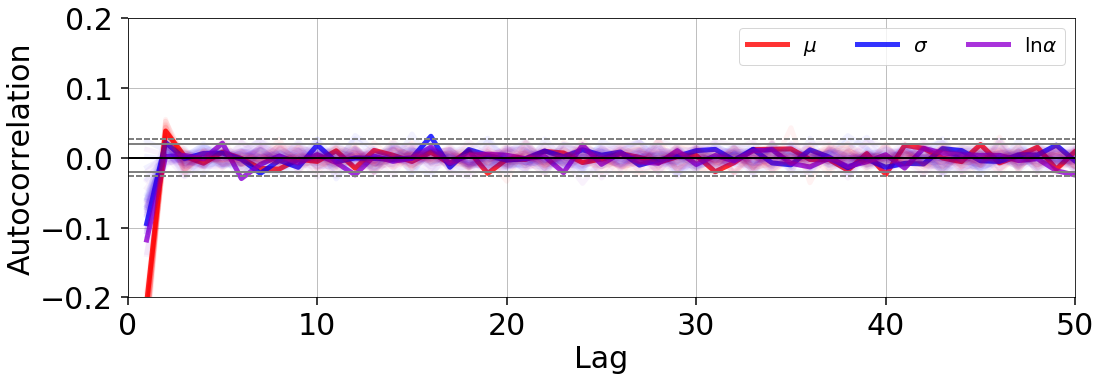

In [12]:
from pandas.tools.plotting import autocorrelation_plot # autocorrelation plot

Nburnin = 500 # burn-in
varnames = [r'$\mu$', r'$\sigma$', r'$\ln\alpha$']
varcolors = ['red', 'blue', 'darkviolet']

# plot autocorrelation lag
figure(figsize=(16,6))
h = [autocorrelation_plot(samples[Nburnin:,i], color=varcolors[i], lw=5, alpha=0.8, label=varnames[i])
     for i in xrange(3)]
h = [[autocorrelation_plot(samples[Nburnin:,i+3*j], color=varcolors[i], lw=5, alpha=0.05)
     for i in xrange(3)] for j in xrange(Nlines)]
xlim([0, 50])
ylim([-0.2, 0.2])
legend(loc='best', fontsize=20, ncol=Ntheta)
tight_layout()

Let's now examine our samples.

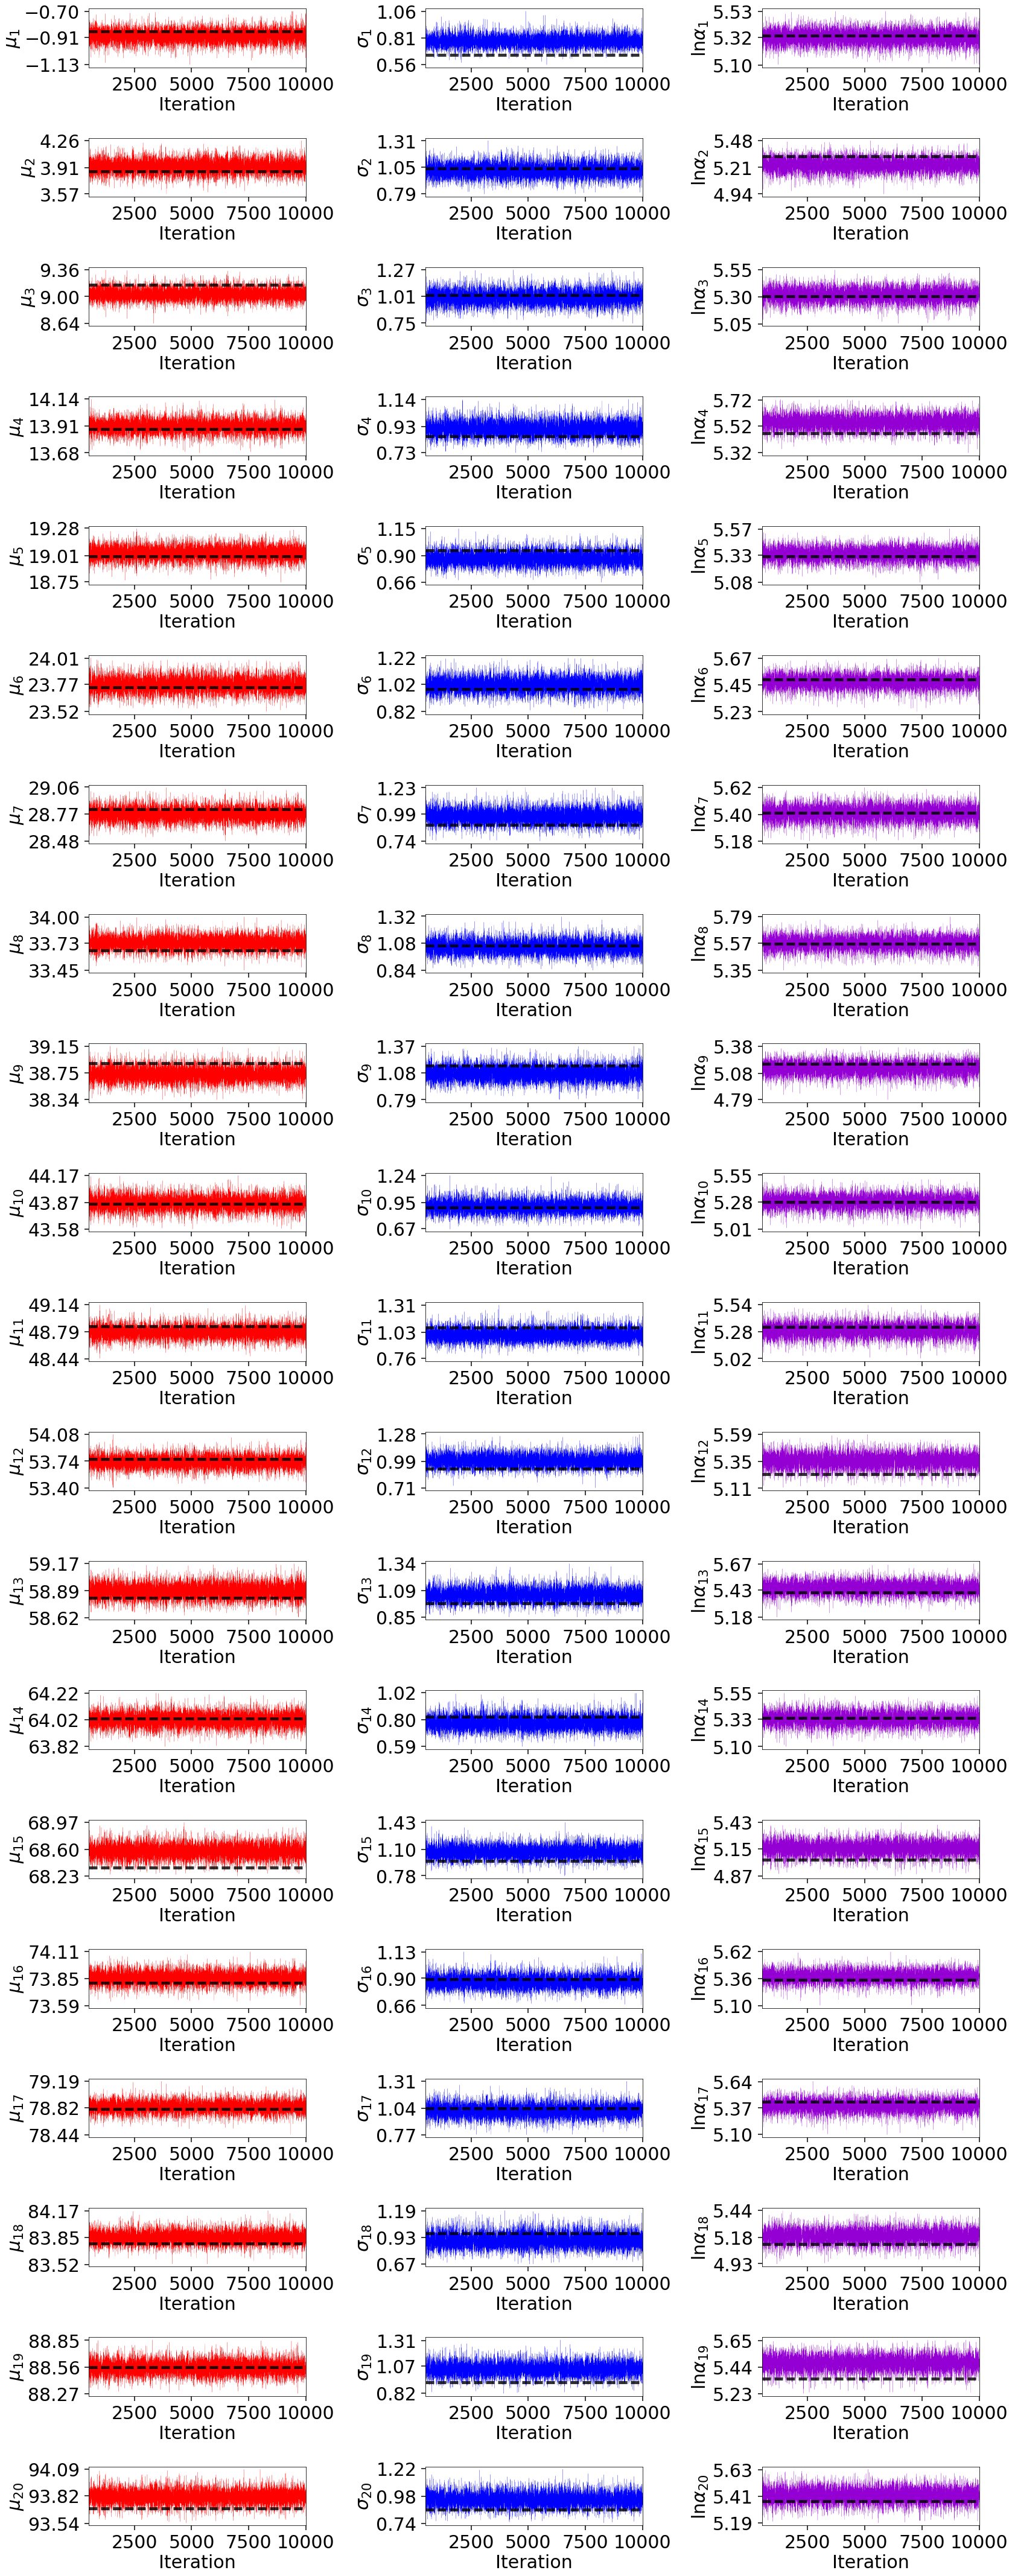

In [13]:
# plot trace
figure(figsize=(24,3*Nlines))
for i in xrange(Nlines):
    for j in xrange(3):
        subplot(Nlines,3,3*i+j+1)
        plot(arange(Nburnin,Nsamples), samples[Nburnin:,3*i+j], lw=0.2, color=varcolors[j], zorder=1)
        hlines(theta_true[3*i+j], Nburnin, Nsamples, colors='black', linestyles='dashed', lw=5, alpha=0.8, zorder=2)
        ymin, ymax = samples[Nburnin:,3*i+j].min(), samples[Nburnin:,3*i+j].max()
        yticks(linspace(ymin, ymax, 3).round(2))
        xlabel('Iteration')
        xticks(linspace(0, Nsamples, 5))
        xlim([Nburnin, Nsamples])
        ylabel(varnames[j]+'$_{'+str(i+1)+'}$')
        tight_layout()

Now that we are probing a 60-dimensional space, it's a bit challenging to plot up all the results in one place on our corner plot. We'll just focus on one line as an illustrative case.

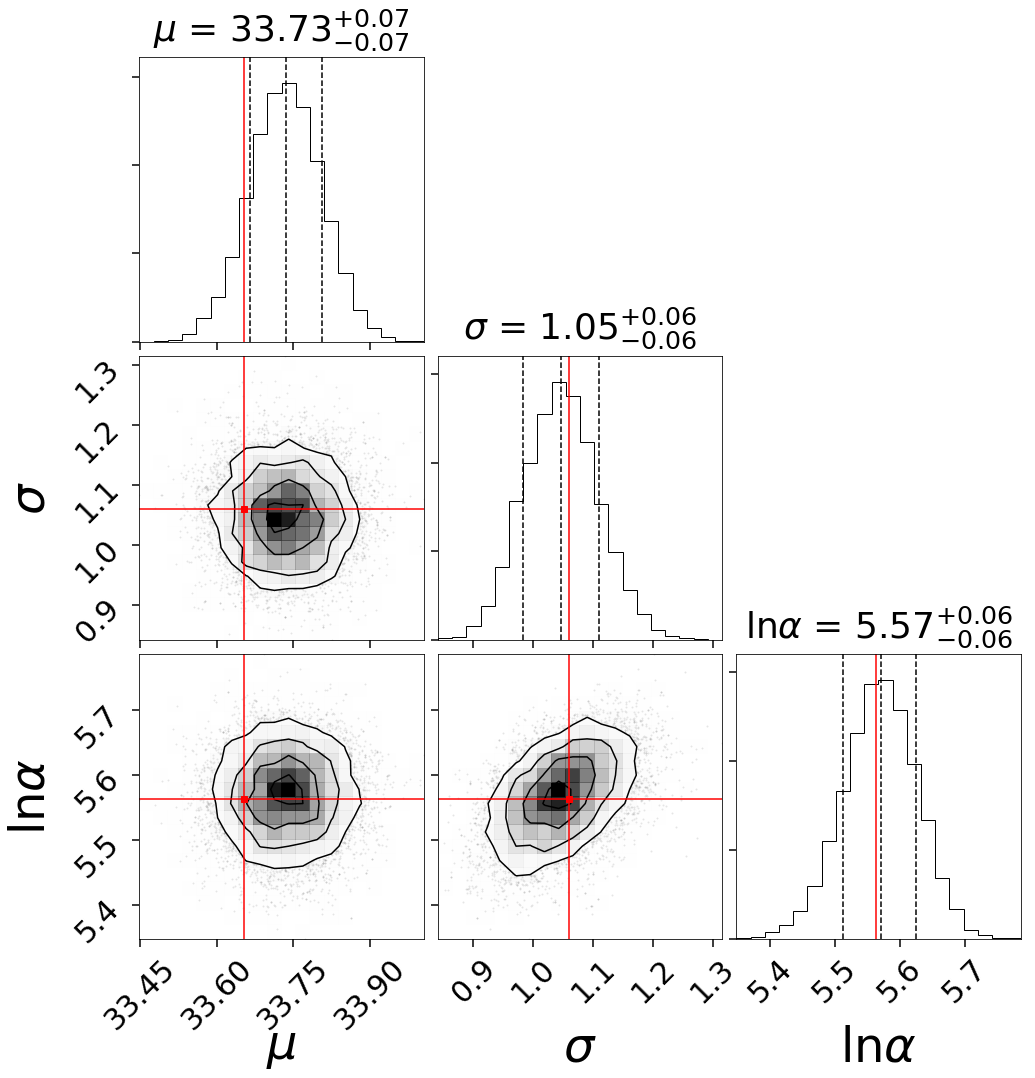

In [16]:
import corner
fig = corner.corner(samples[Nburnin:,21:24], quantiles=[.16, .50, .84],
                    labels=varnames, label_kwargs={'fontsize':48}, 
                    truths=theta_true[21:24], truth_color='red', 
                    show_titles=True, title_kwargs={'y':1.04},
                    fig=subplots(3,3,figsize=(15,15))[0])

Finally, let's see how our fits look relative to the data.

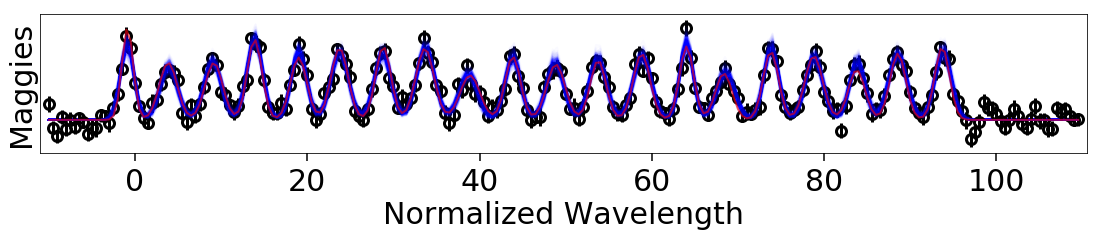

In [17]:
figure(figsize=(16,4))
errorbar(x, y_obs, yerr=y_err, marker='o', markerfacecolor='none', markeredgecolor='black', markeredgewidth=3,
         markersize=10, ecolor='black', lw=3, linestyle='None', zorder=1)
[plot(x, emlines(q), lw=2, alpha=0.02, color='blue', zorder=2) for q in samples[Nburnin::25]]
plot(x, y_true, lw=2, alpha=0.6, color='red', zorder=3)
xlim([x.min()-1, x.max()+1])
yticks([])
xlabel('Normalized Wavelength')
ylabel('Maggies')
tight_layout()